Общий пайлайн решения задачи такой: \
1. Загрузка и преодобработка датафрейма с данными и боксах для каждого изображения.
2. Деление всей трейновой выборки на несколько стратифицированных по определенным значениям, чтобы в каждый фолд  попали примерно одинаковые изображения и потом можно было накаждом фолде обучить модель и объеденить их в ансамбль.
3. Создание загрузчика данных, который их сразу будет аугментировать.
4. Загрузка и определение модели. В нашем случае будем использовать FasterRCNN c backbone  из resnet50.
5. Определяем оптимизатор и lr scheduler
6. Запускаем цикл обучения. На каждой эпохе будет считаться лосс на тренировочной выборке и на валидационной. Также будем высчитывать метрику MAP (Mean average precision). Чтобы отслеживать как модель учиться детектировать, будем выводить одно изображение с заданными боксами и с задетектированными.

In [ ]:
# Датасет был заранее загружен в Google Drive
!unzip /content/drive/My\ Drive/Global_Wheat_Detection/global-wheat-detection.zip -d data

In [ ]:
# Зависимости на машинах Kaggle, приводим в соответствие
!pip install -U git+https://github.com/albumentations-team/albumentations # '0.4.5'
!pip install torch=='1.4.0'
!pip install torchvision=='0.5.0'

In [ ]:
import pandas as pd
import numpy as np
import random
import cv2
import os
import re
from copy import deepcopy
from time import time
from tqdm import tqdm_notebook


import numba
import ast
from numba import jit
from typing import List, Union, Tuple

from PIL import Image
from sklearn.model_selection import StratifiedKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler

from matplotlib import pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# Обязательно фиксируем сиды во всех возможных случаях,
# чтобы обеспечить воспроизводимость при разных запусках.
# Особенно это важно, так как будет разбиение выборки на фолды и параллельное обучение
# на разных машинах
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [ ]:
# Фиксируем номер фолда выборки (от 0 до 4)
# Выбираем директорию для сохранения модели и истории обучения
NUM_WORKERS = 4
TRAIN_BATCH_SIZE = 10
VAL_BATCH_SIZE = 6
FOLD = 0
DATA_PATH = 'data'
DATA_IMAGE_PATH = 'data/train'
PATH_TO_SAVE = '/content/drive/My Drive/Global_Wheat_Detection/final'
MODEL_NAME = f"FasterRCNN_aug_cutmix_fold_{FOLD}.pth"

In [ ]:
# Создаем директорию, если еще нет
# !mkdir /content/drive/My\ Drive/Global_Wheat_Detection/final

In [ ]:
# Загружаем датафрейм с координатами боксов
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [ ]:
# Приводим координаты боксов к нужному виду
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [ ]:
# Делим выборку и стратифицируем их по источнику изображения (зависит от региона происхождения)
# и по количеству боксов на изображении
# Дальше в соответствии с номером фолда изображения, мы будем его вытаскивать

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = train_df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = train_df[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

df_folds.head()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,bbox_count,source,stratify_group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,1
005b0d8bb,20,usask_1,usask_1_1,3
006a994f7,25,inrae_1,inrae_1_1,1
00764ad5d,41,inrae_1,inrae_1_2,0
00b5fefed,25,arvalis_3,arvalis_3_1,3


In [ ]:
class WheatDataset(Dataset):
    """
    Класс для извлечения изображений и аугментации
    
    """

    def __init__(self, df, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.df = df
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        # Если поставлен флаг test, то не делаем cutmix аугментацию
        # Если идет обучение, то делаем сutmix с вероятностью 0.5
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # Только один класс, поэтому все единицы
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        # Площадь боксов на изображении
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Возвращаем словарь с нужными полями
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area

        # Если дан набор аугментаций прогоняем его до 10 раз,
        # пока не получим хотя бы один бокс на итоговом изображении
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })

                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    break


        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        """
        returns: загружает изображение и делает первичную предобработку
        """
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_IMAGE_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # Меняем порядок каналов
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # Нормализация
        image /= 255.0
        # Получаем координаты боксов
        records = self.df[self.df['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        # Переводим координаты из coco в pascal_voc формат и дальше только его и будем использовать
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        Аугментация от автора YOLO https://github.com/ultralytics/yolov3
        Рефакторинг и адаптация: https://www.kaggle.com/shonenkov
        
        Из нескольких изображений мозаикой делаем одно,
        дает неплохой прирост в качестве

        """
        w, h = imsize, imsize
        s = imsize // 2
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b
            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]

        return result_image, result_boxes

In [ ]:
# Формируем сет аугментаций
def get_train_transforms():
    return A.Compose(
        [
            # Кроп до меньшего размера
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            # Цветовая коррекция, или изменение яркости, HSV значений
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            # Повороты и проверка на сохранение исходного размера
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=1024, width=1024, p=1.0),
            # Вырезаем фиксированные куски изображения
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


In [ ]:
# обертка в jit из библиотеки numba ускоряет вычислениe метрики

@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Вычисляет Intersection over Union

    Args:
        gt: (np.ndarray[Union[int, float]]) координаты реальных боксов
        pr: (np.ndarray[Union[int, float]]) координаты предсказанных боксов
        form: (str) формат координат
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        # переводим  в pascal_voc
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Вычисляем площадь перекрытия
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1
    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Вычисляем площадь объединения
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [ ]:
@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Возвращает индекс лучшего пересечения
    между реальными боксами и предсказанными.
    Определяется по наивысшему IoU.

    Args:
        gts: (List[List[Union[int, float]]]) Координаты доступных реальных боксов
        pred: (List[Union[int, float]]) Координаты предсказанных боксов
        pred_idx: (int) Индекс текущего предсказанного бокса
        threshold: (float) Threshold
        form: (str) формат координат
        ious: (np.ndarray) len(gts) x len(preds) матрица для хранения вычисленных iou

    Return:
        (int) Индекс реального бокса с лучшим пересечением (-1 если нет совпадения выше threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # GT уже заматчен
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]
        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Вычисляет precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Координаты доступных реальных боксов
        preds: (List[List[Union[int, float]]]) Координаты предсказанных боксов
                                               отсортированных по убыванию скора
        threshold: (float) Threshold
        form: (str) формат координат
        ious: (np.ndarray) len(gts) x len(preds) матрица для хранения iou

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: Предсказанные боксы соответствуют реальных боксам с IoU выше отсечки
            tp += 1
            # Удаляем сматченный реальный бокс
            gts[best_match_gt_idx] = -1

        else:
            # Нет соответствия
            # False positive: у предсказанного бокса нет соответсвующего ему реального
            fp += 1

    # False negative: реальный бокс не имеет соответствующего ему предсказанного бокса
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Вычисляет среднее precision в соответствии с разными отсечками IoU (Mean Average Precision).

    Args:
        gts: (List[List[Union[int, float]]]) координаты реальных боксов
        preds: (List[List[Union[int, float]]]) координаты предсказанных боксов,
                                            отсортированных по убыванию скора
        thresholds: (float) разные отсечки
        form: (str) формат координат

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [ ]:
# загружаем модель предобученну на датасете COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Заменяем классификатор в соответствии с количеством классов в нашей задаче
num_classes = 2  # 1 класс (головка пшеницы)  и background
# получаем количество фич
in_features = model.roi_heads.box_predictor.cls_score.in_features
# заменяем предобученную голову на новую
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# В трейновую выборку загружаем все изображения, кроме одного фолда
# фолд загружаем в валидационную выборку

fold_number = FOLD

train_dataset = WheatDataset(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    df=train_df,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = WheatDataset(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    df=train_df,
    transforms=get_valid_transforms(),
    test=True,
)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn,
    )
val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=VAL_BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


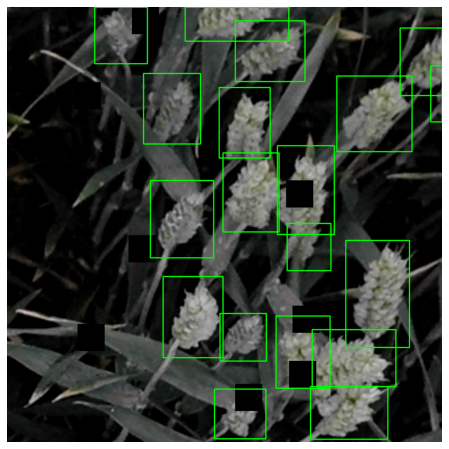

In [ ]:
image, target, image_id = train_dataset[2]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]),
                  (box[2], box[3]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.AdamW(params, lr = 0.0002)


num_epochs = 40

In [ ]:
# Понижаем lr, когда нет улучшения 2 эпохи
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer = optimizer,
        mode='max',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [ ]:
!nvidia-smi

Wed Jul  1 13:56:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    37W / 250W |    887MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class Detector():
    """
    Класс для обучения детектора

    """
    def __init__(self, model, optimizer, num_epochs, lr_scheduler=None, device=torch.device('cuda:0')):
        self.model = model.to(device).float()
        self.opt = optimizer
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.num_epochs = num_epochs

    def fit(self, train_loader, val_loader):
        history = []
        best_map = 0.
        since = time()

        for epoch in range(num_epochs):
            # Тренируем
            epoch_loss = self.train_one_epoch(epoch, train_loader)
            # Валидируем
            metric = self.validate(val_loader)
            
            history.append((epoch_loss, metric))

            # Сохраняем веса если MAP превысил предыдущий лучший результат
            if metric > best_map:
                best_map = metric
                torch.save(self.model.state_dict(), f"{PATH_TO_SAVE}/{MODEL_NAME}") 

            if lr_scheduler is not None:
                lr_scheduler.step(metric)

            self.show_results(best_map, history, val_loader)
        time_elapsed = time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
        
        # Сохраняем историю обучения
        with open(f"{PATH_TO_SAVE}/history.txt", 'w') as f:
            for line in history:
                f.write(','.join([str(i) for i in line])+'\n')

    def train_one_epoch(self, epoch, train_loader):
        self.model.train()
        avg_train_loss = 0
        with tqdm_notebook(desc=f"Epoch {epoch}/{self.num_epochs}", total=len(train_loader), position=0) as pbar:
            for images, targets, image_ids in train_loader:
                images = torch.stack(images)
                images = images.to(self.device)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                loss_dict = self.model(images, targets)

                # суммируем регрессионные и классификационные лоссы
                losses = sum(loss for loss in loss_dict.values())
                loss_value = losses.item()

                avg_train_loss += loss_value / len(train_loader)

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                pbar.update(1)
                
        return avg_train_loss

    def validate(self, val_loader):
        self.model.eval()
        validation_image_precisions = []
        
        iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
        with tqdm_notebook(desc=f"Validation", total=len(val_loader), position=0) as pbar_inner:
            for images, targets, image_ids in val_loader:
                with torch.no_grad():
                    images = torch.stack(images)
                    images = images.to(self.device)
                    outputs = self.model(images)

                preds = [image['boxes'] for image in outputs]
                preds = torch.cat(preds).to('cpu').numpy()
                scores = [image['scores'] for image in outputs]
                scores = torch.cat(scores).to('cpu').numpy()

                gt_boxes = [image['boxes'] for image in targets]
                gt_boxes = torch.cat(gt_boxes).to('cpu').numpy()
                # Сортируем боксы по убыванию скоров
                preds_sorted_idx = np.argsort(scores)[::-1]
                preds_sorted = preds[preds_sorted_idx]

                for idx, image in enumerate(images):
                    # для всех изображений в батче считаем MAP
                    image_precision = calculate_image_precision(preds_sorted,
                                                                gt_boxes,
                                                                thresholds=iou_thresholds,
                                                                form='pascal_voc')

                    validation_image_precisions.append(image_precision)
                pbar_inner.update(1)

        return np.mean(validation_image_precisions)

    def show_results(self, best_map, history, data_loader):
        # Рисуем лосс на трейне и MAP
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        train_loss, mean_av_pres = zip(*history)
        ax[0].plot(mean_av_pres, label='MAP')
        ax[0].legend(loc='best')
        ax[0].grid()
        ax[1].plot(train_loss, label='train loss')
        ax[1].legend(loc='best')
        ax[1].grid()

        plt.suptitle(f"Train loss: {history[-1][0]:.4f} | MAP: {history[-1][1]:.4f} | Best MAP {best_map:.4f} | lr: {optimizer.param_groups[0]['lr']}")


        # Рисуем предсказанные и реальные боксы, чтобы отслеживать прогресс
        images, targets, image_ids = next(iter(data_loader))
        images = list(img.to(device) for img in images)
        targets = [{k: v.to('cpu') for k, v in t.items()} for t in targets]
        boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
        model.eval()
        with torch.no_grad():
            outputs =self.model(images)

        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        pred_boxes = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)
        scores = outputs[0]['scores'].cpu().detach().numpy().astype(np.float32)

        numpy_image = images[0].permute(1,2,0).cpu().numpy()
        sample = deepcopy(numpy_image)
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))

        for box in boxes:
            cv2.rectangle(numpy_image, (box[0], box[1]),
                    (box[2], box[3]), (0, 1, 0), 2)

        for i, box in enumerate(pred_boxes):
            if scores[i] > 0.5:
                cv2.rectangle(sample, (box[0], box[1]),
                        (box[2], box[3]), (0, 1, 0), 2)

        ax[0].imshow(numpy_image);
        ax[0].set_title('Real boxes')

        ax[1].imshow(sample)
        ax[1].set_title('Predicted boxes')

        plt.show()

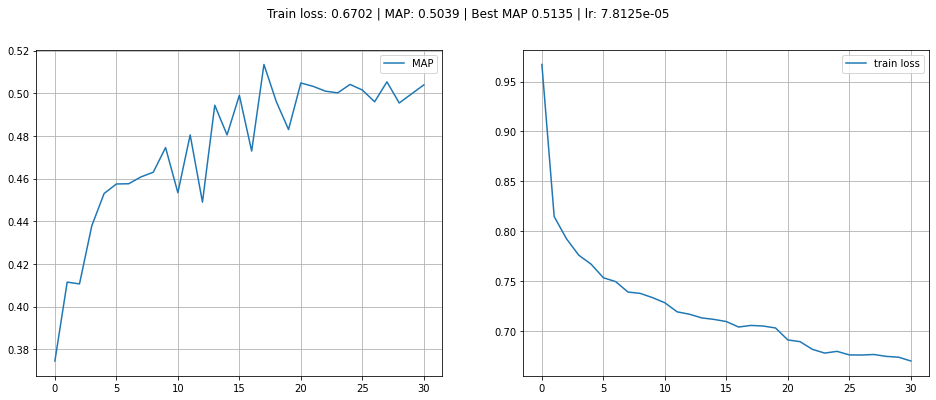

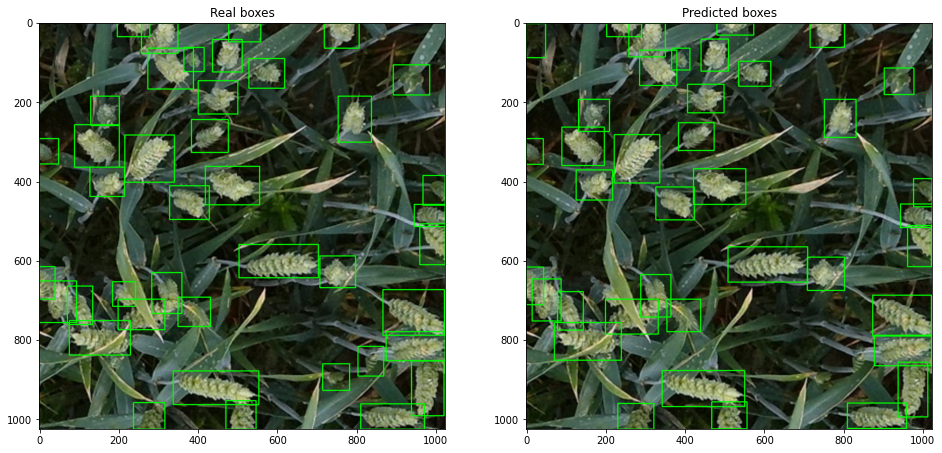

KeyboardInterrupt: ignored

In [ ]:
detector = Detector(model, optimizer, num_epochs, lr_scheduler)
detector.fit(train_loader, val_loader)